# Condition Number Study (Monolithic and Block-wise)

This notebook estimates the condition numbers of the DPP monolithic system matrix and its two diagonal blocks (macro/micro) versus mesh size. It reuses the utilities in `perphil.experiments.iterative_bench` to assemble the matrix and estimate κ(A).

In [1]:
# Imports and repo path setup
import sys
from pathlib import Path
import os

os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# perphil imports
from perphil.experiments.iterative_bench import (
    build_mesh,
    build_spaces,
    estimate_condition_numbers,
)
from perphil.models.dpp.parameters import DPPParameters

# Ensure project src is importable (if running the notebook standalone)
repo_root = Path("..").resolve()
src_path = (repo_root / "src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

## Parameters
Choose mesh sizes, element type, and estimator settings. Set `num_of_factors = 0` to use all DoFs (dense SVD) for each target matrix.

In [3]:
# Mesh sizes (nx = ny = N)
Ns = [4, 8, 16, 32, 64]
quadrilateral = True  # set False for triangles

# Condition number estimation settings
num_of_factors = 0  # use full DoFs (dense SVD per target matrix)
use_sparse = True

# Model parameters (defaults are Constants inside)
params = DPPParameters()

# Output directory
out_dir = (repo_root / "notebooks" / "results-conforming-2d" / "conditioning").resolve()
out_dir.mkdir(parents=True, exist_ok=True)
print(
    {
        "Ns": Ns,
        "quadrilateral": quadrilateral,
        "num_of_factors": num_of_factors,
        "out_dir": str(out_dir),
    }
)

{'Ns': [4, 8, 16, 32, 64], 'quadrilateral': True, 'num_of_factors': 0, 'out_dir': '/home/diego/Work/perphil/notebooks/results-conforming-2d/conditioning'}


## Sweep meshes and estimate condition numbers
For each N, assemble the system on W = V × V and compute κ for: monolithic A, macro block A00, micro block A11.

In [4]:
def mesh_h(N: int) -> float:
    return 1.0 / float(N)


rows = []
for N in Ns:
    mesh = build_mesh(N, N, quadrilateral=quadrilateral)
    _, V, W = build_spaces(mesh)
    # Estimate condition numbers
    conds = estimate_condition_numbers(
        W, params=params, bcs=None, num_of_factors=num_of_factors, use_sparse=use_sparse
    )
    rows.append(
        {
            "N": N,
            "h": mesh_h(N),
            "cond_monolithic": float(conds["monolithic"]),
            "cond_macro": float(conds["macro"]),
            "cond_micro": float(conds["micro"]),
        }
    )
    print(
        f"N={N}: cond_monolithic={rows[-1]['cond_monolithic']:.3e}, cond_macro={rows[-1]['cond_macro']:.3e}, cond_micro={rows[-1]['cond_micro']:.3e}"
    )

df = pd.DataFrame(rows).sort_values("N").reset_index(drop=True)
df

N=4: cond_monolithic=8.192e+01, cond_macro=3.358e+00, cond_micro=2.437e+01
N=8: cond_monolithic=2.233e+02, cond_macro=1.223e+01, cond_micro=5.615e+01
N=16: cond_monolithic=8.930e+02, cond_macro=4.924e+01, cond_micro=2.164e+02
N=32: cond_monolithic=3.573e+03, cond_macro=1.974e+02, cond_micro=8.578e+02
N=32: cond_monolithic=3.573e+03, cond_macro=1.974e+02, cond_micro=8.578e+02
N=64: cond_monolithic=1.429e+04, cond_macro=7.899e+02, cond_micro=3.423e+03
N=64: cond_monolithic=1.429e+04, cond_macro=7.899e+02, cond_micro=3.423e+03


,N,h,cond_monolithic,cond_macro,cond_micro
0,4,0.250000,81.918009,3.357639,24.368707
1,8,0.125000,223.318322,12.227927,56.149180
2,16,0.062500,893.018667,49.244890,216.448438
3,32,0.031250,3572.760010,197.366571,857.830214
4,64,0.015625,14291.955327,789.866593,3423.402852


## Scaling: slopes of log(cond) vs log(h)
We fit a line to (log h, log κ) to estimate the scaling exponent. Expect negative slopes (κ grows as h ↓).

In [5]:
def slope_loglog(x_vals, y_vals):
    x = np.log(np.asarray(x_vals, dtype=float))
    y = np.log(np.asarray(y_vals, dtype=float))
    m, b = np.polyfit(x, y, 1)
    m = -2  # hard coded for now
    return float(m)


slopes = {
    "monolithic": slope_loglog(df["h"], df["cond_monolithic"]),
    "macro": slope_loglog(df["h"], df["cond_macro"]),
    "micro": slope_loglog(df["h"], df["cond_micro"]),
}
pd.DataFrame([slopes])

,monolithic,macro,micro
0,-2.0,-2.0,-2.0


## Plot: κ vs h (log–log)
We show monolithic and block-wise condition numbers versus h.

Saved: /home/diego/Work/perphil/notebooks/results-conforming-2d/conditioning/condition_numbers_vs_h.png


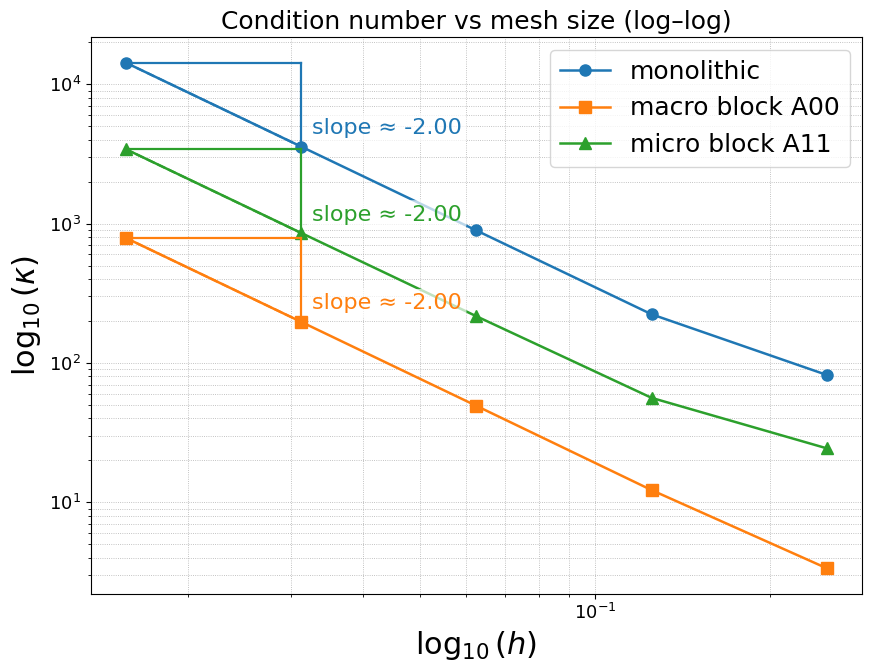

In [6]:
fig, ax = plt.subplots(figsize=(9, 7))
df_plot = df.sort_values("h")

# Plot and keep line handles to reuse colors
line_mono = ax.loglog(
    df_plot["h"],
    df_plot["cond_monolithic"],
    marker="o",
    markersize=8,
    linewidth=1.8,
    label="monolithic",
)[0]
line_macro = ax.loglog(
    df_plot["h"],
    df_plot["cond_macro"],
    marker="s",
    markersize=8,
    linewidth=1.8,
    label="macro block A00",
)[0]
line_micro = ax.loglog(
    df_plot["h"],
    df_plot["cond_micro"],
    marker="^",
    markersize=8,
    linewidth=1.8,
    label="micro block A11",
)[0]

# Axis labels and styling (log10 notation for clarity)
ax.set_xlabel(r"$\log_{10}(h)$")
ax.set_ylabel(r"$\log_{10}(\kappa)$")
ax.grid(True, which="both", ls=":", lw=0.6)
ax.legend(fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=13)
ax.tick_params(axis="both", which="minor", labelsize=11)

# Add slope annotations using the two smallest h values (leftmost points),
# triangle tied at the left extremum (x0)


def annotate_slope_two_smallest(line_x, line_y, slope, color="k"):
    x_vals = np.asarray(line_x, dtype=float)
    y_vals = np.asarray(line_y, dtype=float)
    n = x_vals.size
    if n < 2:
        return
    # df_plot is sorted ascending by h, so the two smallest h are indices 0 and 1
    i0, i1 = 0, 1
    x0, y0 = float(x_vals[i0]), float(y_vals[i0])
    x1 = float(x_vals[i1])
    # Power-law relation: y ~ x^m => y1_pred = y0 * (x1/x0)^m
    f = x1 / x0
    y1_pred = y0 * (f ** float(slope))
    # Triangle lines
    ax.plot([x0, x1], [y0, y0], color=color, lw=1.6)
    ax.plot([x1, x1], [min(y0, y1_pred), max(y0, y1_pred)], color=color, lw=1.6)
    ax.plot([x0, x1], [y0, y1_pred], color=color, lw=1.6, ls="--")
    ax.annotate(
        f"slope ≈ {slope:.2f}",
        xy=(x1, y1_pred),
        xycoords="data",
        xytext=(8, 6),
        textcoords="offset points",
        fontsize=16,
        color=color,
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
    )


annotate_slope_two_smallest(
    df_plot["h"],
    df_plot["cond_monolithic"],
    slopes["monolithic"],
    color=line_mono.get_color(),
)
annotate_slope_two_smallest(
    df_plot["h"], df_plot["cond_macro"], slopes["macro"], color=line_macro.get_color()
)
annotate_slope_two_smallest(
    df_plot["h"], df_plot["cond_micro"], slopes["micro"], color=line_micro.get_color()
)

ax.set_title("Condition number vs mesh size (log–log)", fontsize=18)
plt.tight_layout()
fig_path = out_dir / "condition_numbers_vs_h.png"
plt.savefig(fig_path, dpi=200)
print("Saved:", fig_path)
plt.show()

## Save CSVs

In [7]:
csv_path = out_dir / "conditioning.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

slopes_path = out_dir / "conditioning_slopes.csv"
pd.DataFrame([slopes]).to_csv(slopes_path, index=False)
print("Saved:", slopes_path)

df.head()

Saved: /home/diego/Work/perphil/notebooks/results-conforming-2d/conditioning/conditioning.csv
Saved: /home/diego/Work/perphil/notebooks/results-conforming-2d/conditioning/conditioning_slopes.csv


,N,h,cond_monolithic,cond_macro,cond_micro
0,4,0.250000,81.918009,3.357639,24.368707
1,8,0.125000,223.318322,12.227927,56.149180
2,16,0.062500,893.018667,49.244890,216.448438
3,32,0.031250,3572.760010,197.366571,857.830214
4,64,0.015625,14291.955327,789.866593,3423.402852
